# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')

In [4]:
print type(X_train), X_train.dtype
print type(y_train), y_train.dtype
print type(X_test), X_test.dtype
print type(y_test), y_test.dtype

<type 'numpy.ndarray'> float32
<type 'numpy.ndarray'> uint8
<type 'numpy.ndarray'> float32
<type 'numpy.ndarray'> uint8


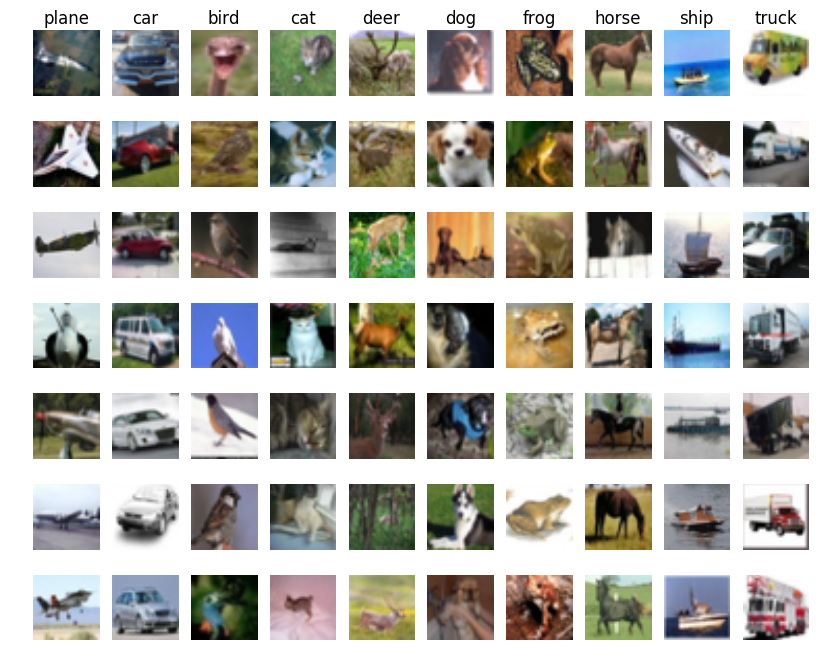

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne.layers import get_output
theano.config.floatX='float32'

input_X = T.tensor4("X")
target_y = T.vector("target Y integer", dtype='int64')
#target_y = target_y.astype(np.int32) 

//anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Так задаётся архитектура нейронки

In [7]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)
print input_layer.shape

net_conv1 = lasagne.layers.Conv2DLayer(input_layer, num_filters=64, filter_size=5)
net_pool1 = lasagne.layers.Pool2DLayer(net_conv1, pool_size=2)
#net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=10, filter_size=5)
#net['pool2'] = lasagne.layers.Pool2DLayer(net['conv2'], pool_size=2)

#Fully-connected + dropout
net_fc1 = lasagne.layers.DenseLayer(net_pool1, num_units=100)
print net_fc1.output_shape
#net_drop1 = lasagne.layers.DropoutLayer(net_fc1,  p=0.5)

#nnet = lasagne.layers.DenseLayer(input_layer,num_units=256, nonlinearity=sigmoid, name="hidden_dense_layer1")
#nnet = lasagne.layers.DenseLayer(nnet,num_units=128, nonlinearity=sigmoid, name="hidden_dense_layer2")
#nnet = lasagne.layers.DenseLayer(nnet,num_units=64, nonlinearity=sigmoid, name="hidden_dense_layer3")

# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense_output = lasagne.layers.DenseLayer(net_fc1, num_units = 10, nonlinearity=softmax, name='output')
print dense_output.output_shape

(None, 3, 32, 32)
(None, 100)
(None, 10)


In [8]:
#предсказание нейронки (theano-преобразование)
y_predicted = get_output(dense_output)

//anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [9]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, output.W, output.b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [10]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

def categorical_accuracy(predictions, targets, top_k=1):

    if targets.ndim == predictions.ndim:
        targets = theano.tensor.argmax(targets, axis=-1)
    elif targets.ndim != predictions.ndim - 1:
        raise TypeError('rank mismatch between targets and predictions')

    if top_k == 1:
        # standard categorical accuracy
        top = theano.tensor.argmax(predictions, axis=-1)
        return theano.tensor.eq(top, targets)
    else:
        # top-k accuracy
        top = theano.tensor.argsort(predictions, axis=-1)
        # (Theano cannot index with [..., -top_k:], we need to simulate that)
        top = top[[slice(None) for _ in range(top.ndim - 1)] +
                  [slice(-top_k, None)]]
        targets = theano.tensor.shape_padaxis(targets, axis=-1)
        return theano.tensor.any(theano.tensor.eq(top, targets), axis=-1)

accuracy = categorical_accuracy(y_predicted, target_y).mean()

updates_sgd = lasagne.updates.rmsprop(loss, all_weights, learning_rate=0.001)

In [11]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [12]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [13]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 300 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    #val_acc = 0
    #val_batches = 0
    #for batch in iterate_minibatches(X_val, y_val, batch_size):
     #   inputs, targets = batch
     #   val_acc += accuracy_fun(inputs, targets)
     #   val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    #print("  validation accuracy:\t\t{:.2f} %".format(
    #    val_acc / val_batches * 100))

RuntimeError: BaseCorrMM: Failed to allocate output of 300 x 64 x 28 x -1
Apply node that caused the error: CorrMM{valid, (1, 1)}(X, Subtensor{::, ::, ::int64, ::int64}.0)
Toposort index: 15
Inputs types: [TensorType(float32, 4D), TensorType(float32, 4D)]
Inputs shapes: [(300, 32, 32, 3), (64, 3, 5, 5)]
Inputs strides: [(12288, 128, 4, 4096), (300, 100, -20, -4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(CorrMM{valid, (1, 1)}.0, InplaceDimShuffle{x,0,x,x}.0), Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)](TensorConstant{(1, 1, 1, 1) of 0.5}, Elemwise{add,no_inplace}.0, CorrMM{valid, (1, 1)}.0, InplaceDimShuffle{x,0,x,x}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "//anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-0488af5e4c0a>", line 2, in <module>
    y_predicted = get_output(dense_output)
  File "//anaconda/lib/python2.7/site-packages/lasagne/layers/helper.py", line 185, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "//anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py", line 489, in get_output_for
    border_mode=border_mode)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3